In [1]:
import datetime
import pandas as pd
import sklearn
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [2]:
%%time

# load features and target for ML
df_traffic = pd.read_csv('output/austin_2022_GP_10min_interval_delaydifference_with_features_forML_final.csv')
df_traffic = df_traffic.rename(columns={"miles": "segment_length"})

df_traffic['minutes_since_midnight'] = df_traffic['hour_min'].apply(lambda x: int(x[:2]) * 60 + int(x[3:]))
df_traffic = df_traffic[df_traffic['tmc_code']!='112+53808']  # this is a segment disconnected with every road

print('unique road segments (samples):',df_traffic.tmc_code.unique().shape[0])
print('total observations: ',df_traffic.shape[0])
# because the event usually begins in the morning after 10, people arrive typically around that time, so we want to only focus on after 930
df_traffic = df_traffic[df_traffic['minutes_since_midnight']>=540]
print(df_traffic.shape[0]) #866449

# load node embeddings of road network
df_road_embeddings = pd.read_csv('output/network_embeddings.csv')
suffixes = [int(col.split('_')[-1]) for col in df_road_embeddings.columns if col.startswith('embedding_')]
max_embeddings = max(suffixes) if suffixes else None
df_traffic = df_traffic.merge(df_road_embeddings, how='left')
print(df_traffic.shape[0])
df_traffic.head(2)

unique road segments (samples): 3225
total observations:  3549832
2197949
2197949
CPU times: user 16.4 s, sys: 2.93 s, total: 19.3 s
Wall time: 21.8 s


tmc_code hour_min  delay_baseline  delay_focus  delay_difference        date         intersection  start_latitude  start_longitude  end_latitude  end_longitude  segment_length  airbnb_count  distance_to_venue_centroid  distance_to_Shuttle_Waterloo_Park  distance_to_Shuttle_Barton_Creek_Square  distance_to_Shuttle_Expo_Center  segment_bearing                                       osm_id  road_type  oneway  lanes_mean  maxspeed_value  day_of_week  no_devices  no_devices_baseline  no_devices_focus  demand_diff  minutes_since_midnight  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  embedding_30  embedding_31  embedding_32  \
0  112+04760  09:00   -1.06365        -1.30941     -0.24577           2022-10-17  US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True   1.50000     55.00000         0           0.00000     132.00000            108.00000         -24.00000     540                    0.80788      -0.30878     0.48830      0.40444      -0.19644     -0.63592     -0.05096     -0.96207     -0.26387     0.54659      -1.03205      -0.57319      0.58703       -0.90266      0.39712       0.64467       0.02475       -0.13640      -0.42769      0.39307       0.45515       0.69224       0.02814       -0.87651      -0.46587      -0.28346      -0.03728      -0.89838      -0.87812      -0.60183      0.24631       -0.66729      0.74725         
1  112+04760  09:00   -1.06365        -1.30941     -0.24577           2022-10-17  US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True   1.50000     55.00000         0           0.00000     132.00000            33.00000          -99.00000     540                    0.80788      -0.30878     0.48830      0.40444      -0.19644     -0.63592     -0.05096     -0.96207     -0.26387     0.54659      -1.03205      -0.57319      0.58703       -0.90266      0.39712       0.64467       0.02475       -0.13640      -0.42769      0.39307       0.45515       0.69224       0.02814       -0.87651      -0.46587      -0.28346      -0.03728      -0.89838      -0.87812      -0.60183      0.24631       -0.66729      0.74725         

   embedding_33  embedding_34  embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  embedding_60  embedding_61  embedding_62  embedding_63  
0 -0.08435      0.21258       0.50216       -0.85987      -0.10462      0.10216       -0.61296      0.70476       -0.07447      -0.44610      -1.25291      -0.56601      0.08196       0.06211       0.14970       0.23362       -0.72179      0.71536       0.29920       -0.47497      -0.78599      -0.12997      -0.19213      -0.19580      -0.42946      -1.18347      0.54779       -0.78096      0.16931       0.24326       -0.44661       
1 -0.08435      0.21258       0.50216       -0.85987      -0.10462      0.10216       -0.61296      0.70476       -0.07447      -0.44610   

In [5]:
df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]
from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")
gdf_road.head(2)

tmc_code                  intersection  start_latitude  start_longitude  end_latitude  end_longitude   miles                                             geometry
0  112P13033  W MARTIN LUTHER KING JR BLVD 30.28172        -97.74193        30.28232      -97.74207      0.04249  LINESTRING (-97.74193 30.28172, -97.74207 30.28232)
1  112+08908  FM-20                        30.11066        -97.41049        30.11082      -97.37323      2.22783  LINESTRING (-97.41049 30.11066, -97.37323 30.11082)

# Mapping no of devices

In [6]:
df_traffic_vis = df_traffic[['tmc_code','date','hour_min','delay_difference','no_devices_focus']]
gdf_road_merged = gdf_road.merge(df_traffic_vis)
gdf_road_merged.shape[0]

2197949

In [7]:
%%time
date1 = '2022-10-21'
hour_min1 = '13:20'

gdf_road_merged_select = gdf_road_merged[(gdf_road_merged['date']==date1)&(gdf_road_merged['hour_min']==hour_min1)]
print(gdf_road_merged_select.shape[0])
gdf_road_merged_select.explore(
    column='no_devices_focus'
)

3223


# Load the fine-tuned ML model

In [8]:
feature_names = ['minutes_since_midnight', 'segment_length','segment_bearing', 'oneway', 'lanes_mean','road_type', 'maxspeed_value',
                'day_of_week', 'airbnb_count', 'distance_to_venue_centroid', 'no_devices_baseline', 'no_devices_focus'
               ] #'no_devices'

feature_names.extend([f"embedding_{i}" for i in range(max_embeddings)])

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare input features and labels for the model
X = df_traffic[feature_names].copy() 
X['road_type'] = X['road_type'].astype('category')
y = df_traffic['delay_difference'].values

In [9]:
%%time 
import lightgbm as lgb
import joblib

# Load the model back
output_path = './output/lightgbm_model_2025-02-09 13:47:13.515701.pkl'
model = joblib.load(output_path)
print("Model loaded successfully!")
# print(model.feature_name_)

Model loaded successfully!
CPU times: user 989 ms, sys: 65.4 ms, total: 1.05 s
Wall time: 2.56 s


In [12]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(datetime.datetime.now(),'Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y, y_pred)
print(datetime.datetime.now(),'Best Model R-squared: %.3f' % r2) 

2025-02-12 17:46:07.117336 Best Model RMSE: 10.569
2025-02-12 17:46:07.137990 Best Model R-squared: 0.583
CPU times: user 1min 40s, sys: 6.26 s, total: 1min 47s
Wall time: 19.3 s


# Simulation

In [13]:
dayofweek = 4
X_select = X[X['day_of_week']==dayofweek]
print(X_select.shape[0])

290070


In [14]:
%%time
y_pred_select = model.predict(X_select)
# X_select['predicted_diff_delay'] = y_pred_select
df_traffic_select = df_traffic[df_traffic['day_of_week']== dayofweek]
df_traffic_select['predicted_diff_delay'] = y_pred_select
print(df_traffic_select.shape[0])

290070
CPU times: user 13.8 s, sys: 392 ms, total: 14.2 s
Wall time: 2.22 s


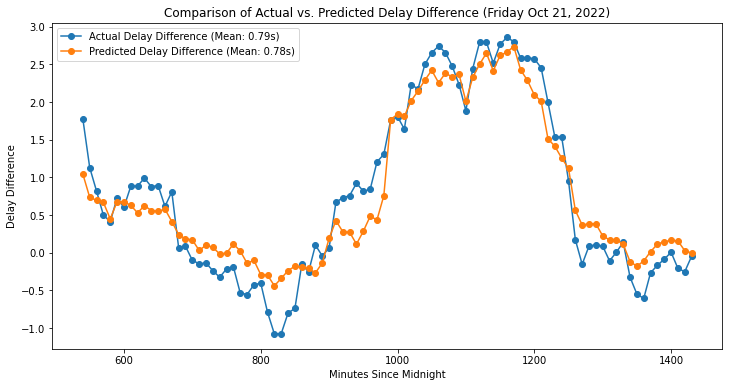

In [18]:
import matplotlib as plt
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Compute mean values
mean_actual = df_traffic_select['delay_difference'].mean()
mean_predicted = df_traffic_select['predicted_diff_delay'].mean()

# Plot the trends
ax = df_traffic_select[['minutes_since_midnight', 'delay_difference', 'predicted_diff_delay']] \
    .groupby('minutes_since_midnight').mean() \
    .plot(figsize=(12, 6), marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Delay Difference")
plt.title("Comparison of Actual vs. Predicted Delay Difference (Friday Oct 21, 2022)")
# plt.grid(True)

# Update legend with mean values
plt.legend([
    f"Actual Delay Difference (Mean: {mean_actual:.2f}s)",
    f"Predicted Delay Difference (Mean: {mean_predicted:.2f}s)"
])

plt.show()

In [19]:
X_select_simu = X_select.copy()
print(X_select_simu.no_devices_focus.describe())
X_select_simu['no_devices_focus'] = X_select_simu['no_devices_focus']/2
print(X_select_simu.no_devices_focus.describe())

y_pred_simu = model.predict(X_select_simu)
df_traffic_simu = df_traffic[df_traffic['day_of_week']== dayofweek]
df_traffic_simu['predicted_diff_delay'] = y_pred_simu
print(df_traffic_simu.shape[0])

count   257425.00000
mean    180.25522   
std     145.96915   
min     1.00000     
25%     76.00000    
50%     144.00000   
75%     234.00000   
max     962.00000   
Name: no_devices_focus, dtype: float64
count   257425.00000
mean    90.12761    
std     72.98458    
min     0.50000     
25%     38.00000    
50%     72.00000    
75%     117.00000   
max     481.00000   
Name: no_devices_focus, dtype: float64
290070


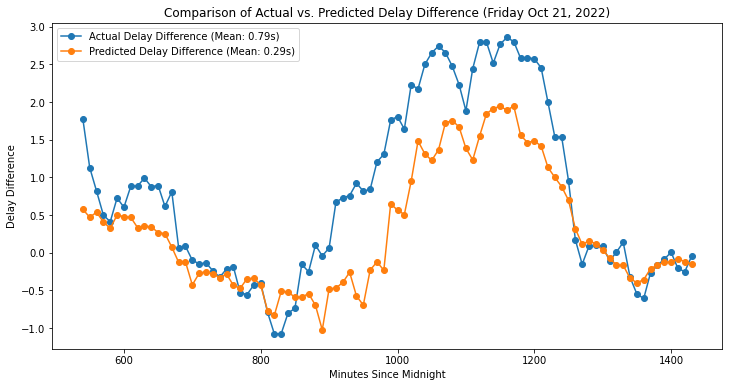

In [20]:
# Compute mean values
mean_actual = df_traffic_simu['delay_difference'].mean()
mean_predicted = df_traffic_simu['predicted_diff_delay'].mean()

# Plot the trends
ax = df_traffic_simu[['minutes_since_midnight', 'delay_difference', 'predicted_diff_delay']] \
    .groupby('minutes_since_midnight').mean() \
    .plot(figsize=(12, 6), marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Delay Difference")
plt.title("Comparison of Actual vs. Predicted Delay Difference (Friday Oct 21, 2022)")
# plt.grid(True)

# Update legend with mean values
plt.legend([
    f"Actual Delay Difference (Mean: {mean_actual:.2f}s)",
    f"Predicted Delay Difference (Mean: {mean_predicted:.2f}s)"
])

plt.show()

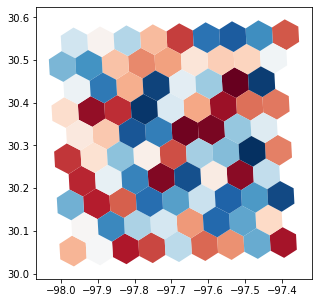

In [21]:
from shapely.geometry import box
import geopandas as gpd
import h3pandas

bound_lat = [30.039047,30.584984]
bound_lon = [-97.996048, -97.389445]
austin_box = gpd.GeoDataFrame(geometry=[box(bound_lon[0],bound_lat[0],bound_lon[1],bound_lat[1])],crs="EPSG:4326")
# austin_box.plot()


resolution = 6 # Average edge length: 3.7km
# H3 resolution list: https://h3geo.org/docs/core-library/restable/
hexagons = austin_box.h3.polyfill_resample(resolution)
ax = hexagons.plot(figsize=(5, 5), cmap='RdBu')
hexagons.drop(['index'], axis=1, inplace=True)
gdf_hexagon = gpd.GeoDataFrame(hexagons, crs="EPSG:4326", geometry='geometry')

In [22]:
%%time

df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]
print('total number of road segments:',df_road.shape[0])
from shapely.geometry import LineString

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame for road network
gdf_road = gpd.GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")

total number of road segments: 4460
CPU times: user 172 ms, sys: 30 ms, total: 202 ms
Wall time: 159 ms


In [23]:
m = gdf_hexagon.explore(
)

gdf_road.explore(
    m=m
)

In [24]:
road_segments_with_hexagon = gpd.sjoin_nearest(
    gdf_hexagon,
    gdf_road,
    how='left',  # Use 'left' to ensure all road segments are preserved
)

In [25]:
df_hexagon_list = road_segments_with_hexagon[['tmc_code']].reset_index()
df_hexagon_list

h3_polyfill   tmc_code
0     86489e2f7ffffff  112-13348
1     86489e22fffffff  112P13178
2     86489e22fffffff  112N13178
3     86489e22fffffff  112+04821
4     86489e22fffffff  112-04820
...               ...        ...
4806  86489e267ffffff  112+13394
4807  86489e267ffffff  112-13393
4808  86489e267ffffff  112+50351
4809  86489e267ffffff  112-50350
4810  86489e38fffffff  112-13331

[4811 rows x 2 columns]

In [26]:
road_list = df_hexagon_list[df_hexagon_list['h3_polyfill']=='86489e327ffffff'].tmc_code.tolist()


In [27]:
X_select_simu = X_select.copy()
print(X_select_simu.no_devices_focus.describe())

df_traffic_simu = df_traffic[df_traffic['day_of_week']== dayofweek]
df_traffic_simu.loc[df_traffic_simu['tmc_code'].isin(road_list), 'no_devices_focus'] /= 2
X_select_simu['no_devices_focus'] = df_traffic_simu['no_devices_focus']
print(X_select_simu.no_devices_focus.describe())

y_pred_simu = model.predict(X_select_simu)
df_traffic_simu['predicted_diff_delay'] = y_pred_simu
print(df_traffic_simu.shape[0])

count   257425.00000
mean    180.25522   
std     145.96915   
min     1.00000     
25%     76.00000    
50%     144.00000   
75%     234.00000   
max     962.00000   
Name: no_devices_focus, dtype: float64
count   257425.00000
mean    179.86734   
std     146.10716   
min     1.00000     
25%     75.00000    
50%     143.00000   
75%     233.00000   
max     962.00000   
Name: no_devices_focus, dtype: float64
290070


In [28]:
# Compute mean values
mean_actual = df_traffic_simu['delay_difference'].mean()
mean_predicted = df_traffic_simu['predicted_diff_delay'].mean()

# Plot the trends
ax = df_traffic_simu[['minutes_since_midnight', 'delay_difference', 'predicted_diff_delay']] \
    .groupby('minutes_since_midnight').mean() \
    .plot(figsize=(12, 6), marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Delay Difference")
plt.title("Comparison of Actual vs. Predicted Delay Difference (Friday Oct 21, 2022)")
# plt.grid(True)

# Update legend with mean values
plt.legend([
    f"Actual Delay Difference (Mean: {mean_actual:.2f}s)",
    f"Predicted Delay Difference (Mean: {mean_predicted:.2f}s)"
])

plt.show()